The **RBM** model

In [1]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class RBM(object):
    def __init__(self, nv=28*28, nh=500, \
                 weight=None, bias_h=None, bias_v=None, rns=None):
        
        self.nv = nv
        self.nh = nh
        
        # initialize parameters
        if rns is None:
            rns = np.random.RandomState(1234)
        
        if weight is None:
            weight = np.array(rns.uniform(low=-4 * np.sqrt(6. / (nh + nv)),
                              high=4 * np.sqrt(6. / (nh + nv)),
                              size=(nv, nh)))

        if bias_h is None:
            bias_h = np.zeros(nh)

        if bias_v is None:
            bias_v = np.zeros(nv)

        self.rns = rns
        self.weight = weight
        self.bias_h = bias_h
        self.bias_v = bias_v
    
    # propagate up
    def propup(self, vis):
        return sigmoid(np.dot(vis, self.weight) + self.bias_h)

    # propagate down
    def propdown(self, hid):
        return sigmoid(np.dot(hid, self.weight.T) + self.bias_v)
    
    # sample h given v
    def v2h(self, v0_sample):
        h1_mean = self.propup(v0_sample)
        h1_sample = self.rns.binomial(size=h1_mean.shape, n=1, p=h1_mean)
        return h1_mean, h1_sample

    # sample v given h
    def h2v(self, h0_sample):
        v1_mean = self.propdown(h0_sample)
        v1_sample = self.rns.binomial(size=v1_mean.shape, n=1, p=v1_mean)
        return v1_mean, v1_sample
    
    # gibbs sampling: h -> v -> h
    def h2v2h(self, h0_sample):
        v1_mean, v1_sample = self.h2v(h0_sample)
        h1_mean, h1_sample = self.v2h(v1_sample)
        return v1_mean, v1_sample, h1_mean, h1_sample

    # gibbs sampling: v -> h -> v
    def v2h2v(self, v0_sample):
        h1_mean, h1_sample = self.v2h(v0_sample)
        v1_mean, v1_sample = self.h2v(h1_sample)
        return v1_mean, v1_sample, h1_mean, h1_sample
    
    # training by taking several sequential states
    def train_step(self, dataset, lr=0.1):
        
        # 2 rounds of encoding and reconstruction
        pos_h_means, pos_h_samples = self.v2h(dataset)
        neg_v_means, neg_h_samples = self.h2v(pos_h_samples)
        nh_means = self.propup(neg_h_samples)
        
        batch_size = dataset.shape[0]

        # gradient descend
        self.weight += lr * (np.dot(dataset.T, pos_h_means) - np.dot(neg_h_samples.T, nh_means)) / batch_size
        self.bias_v += lr * np.mean(dataset - neg_h_samples, axis=0)
        self.bias_h += lr * np.mean(pos_h_means - nh_means, axis=0)
        
        # mean square as the observed cost
        cost = np.mean(np.square(dataset - neg_v_means))
        return cost
    
    # reconstruct by v -> h -> v
    def reconstruct(self, dataset):
        v_mean, _, _, _ = self.v2h2v(dataset)
        return v_mean

The running script (including making figures)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch 0, cost = 0.322537145607
Epoch 1, cost = 0.0794866163815
Epoch 2, cost = 0.0629074823373
Epoch 3, cost = 0.0560704718481
Epoch 4, cost = 0.054912061563
Epoch 5, cost = 0.0530343759485
Epoch 6, cost = 0.0515190094879
Epoch 7, cost = 0.0505089938271
Epoch 8, cost = 0.0494442425576
Epoch 9, cost = 0.0488873144568
Epoch 10, cost = 0.047034600441
Epoch 11, cost = 0.0465423261514
Epoch 12, cost = 0.0448524853237
Epoch 13, cost = 0.0439893026739
Epoch 14, cost = 0.0437483925965
Epoch 15, cost = 0.0431251195076
Epoch 16, cost = 0.0417527698485
Epoch 17, cost = 0.0412437721711
Epoch 18, cost = 0.0408633832132
Epoch 19, cost = 0.0400296546776
Epoch 20, cost = 0.0397601438552
Epoch 21, cost = 0.0394234224132
Epoch 22, cost = 0.0391788382014
Epoch 23, cost = 0.0381355587245
Epoch 24, cost = 0.03793071

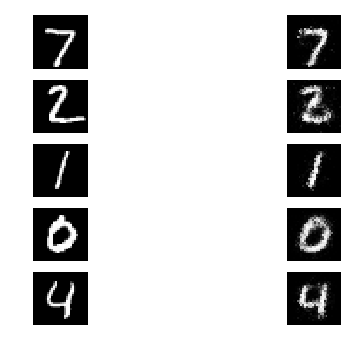

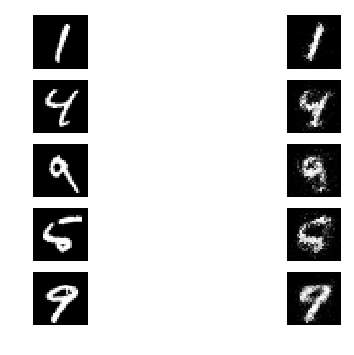

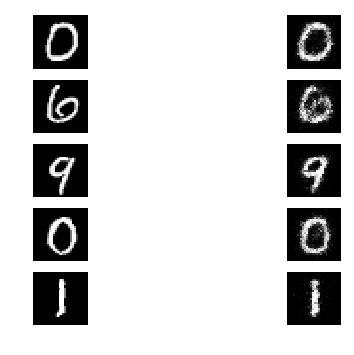

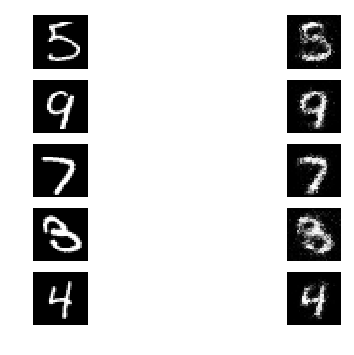

In [1]:
from rbm import RBM
from tensorflow.examples.tutorials.mnist import input_data
from plot_digits import *
import numpy as np

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

rbm = RBM(nv=28 * 28, nh=500)

for epoch in range(100):
    batch_xs, batch_ys = mnist.train.next_batch(1000)
    cost = rbm.train_step(batch_xs, lr=0.1)
    print('Epoch %d, cost =' % epoch, cost)

print('    Visible                        Reonstructed')
for batch in range(4):
    test_x = mnist.test.images[batch * 5 : batch * 5 + 5]
    restore_test = rbm.reconstruct(test_x)
    print_out = []
    for i in range(5):
        print_out += [test_x[i], restore_test[i]]
    print_out = np.array(print_out)
    plot_digits(print_out)